In [2]:
from core import history as ch
from core.fine_model import FineModel
import matplotlib as mpl
import matplotlib.pyplot as plt
import traceback
import warnings
import os

Using TensorFlow backend.


In [3]:
_depth_key = 'EXP{:02}_D{:02}'
_fold_key = 'EXP{:02}_D{:02}_L{:02}_F{:02}'
_epoch_key = 'EXP{:02}_D{:02}_L{:02}_F{:02}_E{:03}'

In [4]:
EXP = 1
K = 5

default_lr_list = [
    0.001,
    0.0001,
    0.00001,
]

metric_names = {
    'val_loss': 'Validation Loss',
    'loss': 'Training Loss',
    'val_acc': 'Validation Accuracy',
    'acc': 'Training Accuracy',
}

In [14]:
def plot_average_by_fold(histories, title=None, ax=None, metric='val_loss'):
    """
    ax: matplotlib.Axes on which to plot the figure
    """
    if metric not in metric_names.keys():
        warnings.warn('Metric "{}" not in metrics. Select one of the following: {}'.format(metric, metric_names.keys()))
        traceback.print_exc()
        fig = plt.Figure()
        return fig
    
    metric_name = metric_names[metric]

    _fold_label = 'Fold #{}'
    avg_label = 'K-Fold Average'
    figsize=(6, 6)
    fold_alpha = 0.5
    xlabel = 'Epochs'
    ylabel = metric_name
    
    if ax is None:
        fig, ax = plt.subplots(squeeze=True, figsize=figsize)
    
    if title is not None:
        ax.set_title(title)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for i, history in enumerate(histories):
        ax.plot(history.index, history[metric], alpha=fold_alpha, label=_fold_label.format(i + 1))

    avg = ch.get_average(histories)[metric]
    ax.plot(avg, label=avg_label)
    ax.legend(loc='upper left')
    ax.grid()
    
    return ax

In [15]:
def plot_average_by_lr(histories_by_lr, title=None, ax=None, metric='val_loss'):
    """
    histories_by_lr: {
        '0.001': list_of_history_dataframes,
        '0.0001': ...,
        ...,
    }
    ax: matplotlib.Axes on which to plot the figure
    """
    if metric not in metric_names.keys():
        warnings.warn('Metric "{}" not in metrics. Select one of the following: {}'.format(metric, metric_names.keys()))
        traceback.print_exc()
        fig = plt.Figure()
        return fig
    
    metric_name = metric_names[metric]

    _fold_label = 'Fold #{}'
    figsize=(6, 6)
    xlabel = 'Epochs'
    ylabel = metric_name
    
    if ax is None:
        fig, ax = plt.subplots(squeeze=True, figsize=figsize)
    
    if title is not None:
        ax.set_title(title)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for lr, histories in histories_by_lr.items():
        avg_history = ch.get_average(histories)
        ax.plot(avg_history.index, avg_history[metric], label='{:.1E}'.format(lr))
    ax.legend(loc='upper left')
    ax.grid()

    return ax

In [16]:
def d3_analyze_depth(fm, verbose_model_name, depth_index, metric, lr_list=default_lr_list):
    model_name = fm.get_name()
    
    print('Analyzing {} D={}, LR={}'.format(verbose_model_name, depth_index, lr_list))

    title = verbose_model_name
    fig, axes = plt.subplots(1, 3, squeeze=True, figsize=(18, 6))
    axes = axes.flatten()
    histories_by_lr = dict()

    for i, ax in enumerate(axes):
        lr = lr_list[i]
        histories = list()
        histories_by_lr[lr] = histories
        for k in range(K):
            fold_key = _fold_key.format(EXP, depth_index, i, k)
            history = ch.load_history(model_name, fold_key)
            histories.append(history)
        path = 'Fold Average [{}][LR={:.1E}][FM={}].png'.format(metric.upper(), lr, model_name)
        single_ax = plot_average_by_fold(histories, title=title, metric=metric)
        single_ax.get_figure().savefig(path, dpi=320, bbox_inches='tight')
        plt.close()
        plot_average_by_fold(histories, title=verbose_model_name, metric=metric, ax=ax)  # for Jupyter

    lr_ax = plot_average_by_lr(histories_by_lr, title=title, metric=metric)
    path = 'LR Average [{}][FM={}].png'.format(metric.upper(), model_name)
    #lr_ax.get_figure().savefig(path, dpi=320, bbox_inches='tight')

In [17]:
def d3_analyze_lr(fm, verbose_model_name, depth_index, lr_index, lr_value, metric):
    model_name = fm.get_name()

    print('Analyzing {} D={}, LR={}'.format(verbose_model_name, depth_index, lr_value))
    title = verbose_model_name
    histories_by_lr = dict()

    histories = list()
    histories_by_lr[lr] = histories
    for k in range(K):
        fold_key = _fold_key.format(EXP, depth_index, lr_index, k)
        history = ch.load_history(model_name, fold_key)
        histories.append(history)
    path = 'Fold Average [{}][LR={:.1E}][FM={}].png'.format(metric.upper(), lr_value, model_name)
    ax = plot_average_by_fold(histories, title=title, metric=metric)
    #ax.get_figure().savefig(path, dpi=320, bbox_inches='tight')

Analyzing MobileNet(a=25) D=0, LR=0.0001


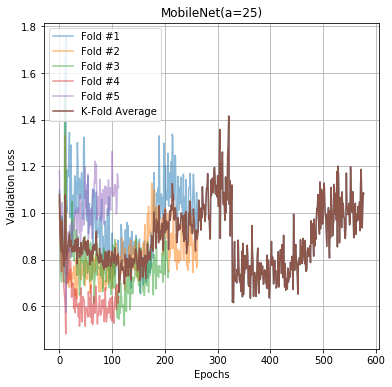

In [18]:
fm = FineModel.get_dict()['mobileneta25']()
verbose_model_name = 'MobileNet(a=25)'
metric='val_loss'
depth_index = 0
lr_index = 0
lr = 0.0001

d3_analyze_lr(fm, verbose_model_name, depth_index=depth_index, lr_index=lr_index, lr_value=lr, metric=metric)

In [9]:
FineModel.get_dict().keys()

dict_keys(['xception', 'mobileneta25', 'mobilenetv2a35', 'vgg16', 'resnet50v2', 'inception_v3', 'inception_resnet_v2', 'densenet121', 'nasnet_mobile'])

Analyzing MobileNetV1 (a=0.25) D=0, LR=[0.001, 0.0001, 1e-05]


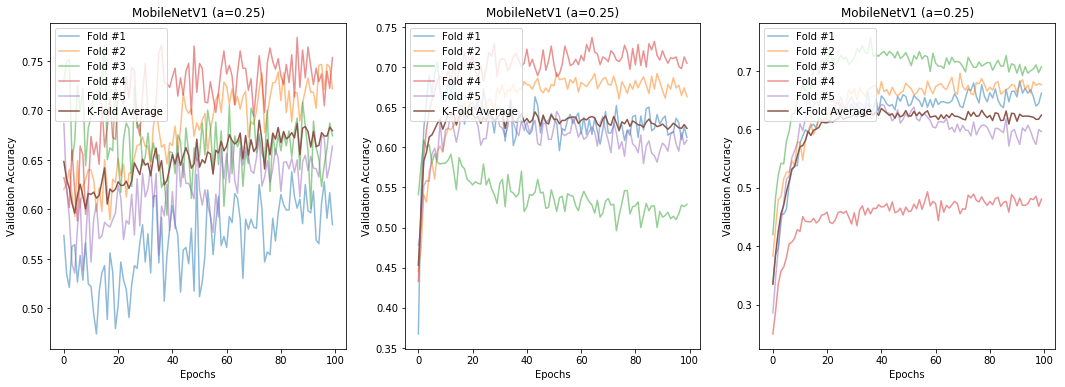

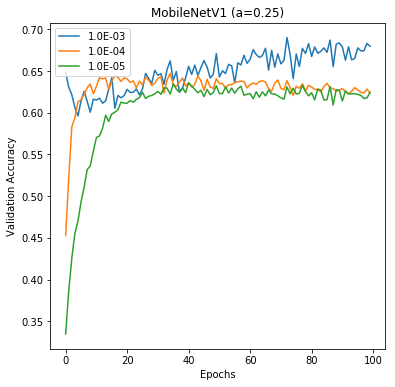

In [10]:
fm = FineModel.get_dict()['mobileneta25']()
verbose_model_name = 'MobileNetV1 (a=0.25)'
metric='val_acc'
depth_index = 0

d3_analyze_depth(fm, verbose_model_name, depth_index=depth_index, metric=metric)